# Simple Moving Averages

## Data Import

In [65]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

In [66]:
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [67]:
raw = pd.read_csv('/Users/cherongtian/Desktop/PythonforFinance/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)

In [68]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
 5   SPY     2138 non-null   float64
 6   .SPX    2138 non-null   float64
 7   .VIX    2138 non-null   float64
 8   EUR=    2216 non-null   float64
 9   XAU=    2211 non-null   float64
 10  GDX     2138 non-null   float64
 11  GLD     2138 non-null   float64
dtypes: float64(12)
memory usage: 225.1 KB


In [69]:
symbol = 'AAPL.O'

In [70]:
data = (
    pd.DataFrame(raw[symbol]).dropna()
)

## Trading Strategy

In [71]:
SMA1 = 42   # calculates the values for the shorter SMA
SMA2 = 252  # calculates the values for the longer SMA

In [72]:
data['SMA1'] = data[symbol].rolling(SMA1).mean()    # calculates the values for the shorter SMA
data['SMA2'] = data[symbol].rolling(SMA2).mean()    # calculates the values for the longer SMA

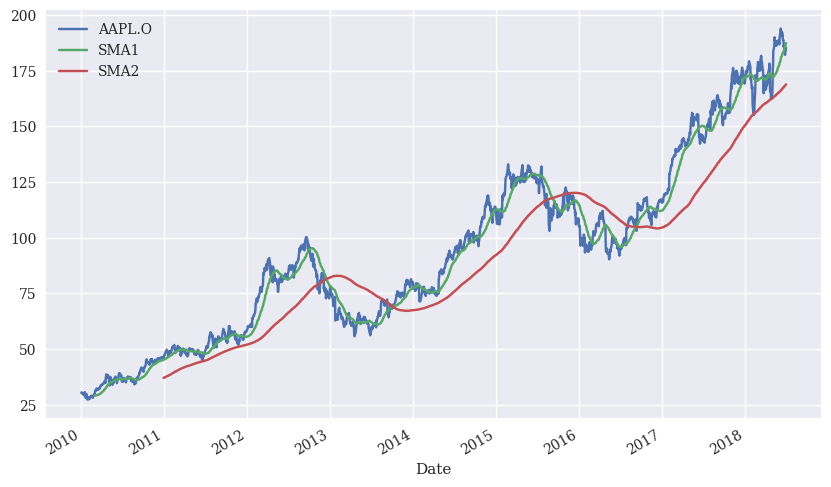

In [73]:
data.plot(figsize=(10, 6));

In [74]:
data.dropna(inplace=True)

In [75]:
data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)    
# np.where(cond, a, b) evaluates the condition cond element-wise and places when True and b otherwise

In [76]:
data.tail()

,AAPL.O,SMA1,SMA2,Position
Date,,,,
2018-06-25,182.17,185.606190,168.265556,1
2018-06-26,184.43,186.087381,168.418770,1
2018-06-27,184.16,186.607381,168.579206,1
2018-06-28,185.50,187.089286,168.736627,1
2018-06-29,185.11,187.470476,168.901032,1


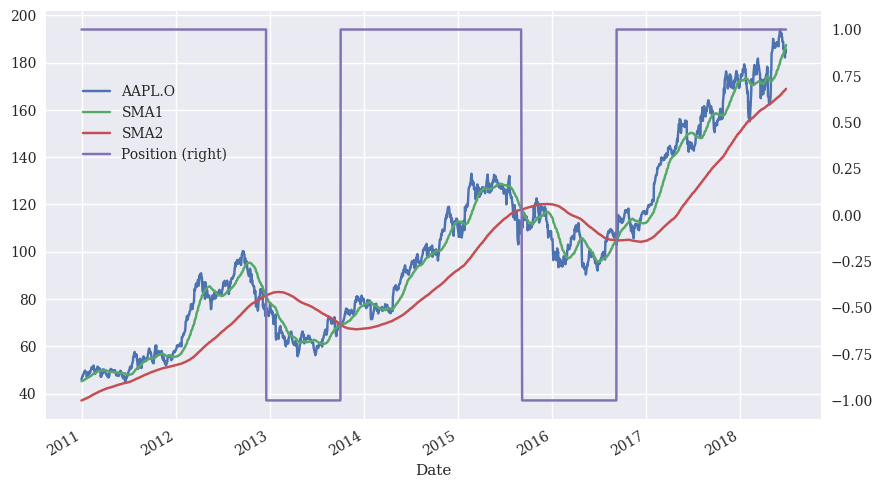

In [77]:
ax = data.plot(secondary_y='Position', figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));

## Vectorized Backtesting

In [78]:
data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))  # calculates the log returns of the Apple stock

In [79]:
data['Strategy'] = data['Position'].shift(1) * data['Returns']  
# Multiples the position values, shifted by one day, by the log returns of the Apple stock; the shift is required to avoid a foresight bias

In [80]:
data.round(4).head()

,AAPL.O,SMA1,SMA2,Position,Returns,Strategy
Date,,,,,,
2010-12-31,46.0800,45.2810,37.1207,1,NaN,NaN
2011-01-03,47.0814,45.3497,37.1862,1,0.0215,0.0215
2011-01-04,47.3271,45.4126,37.2525,1,0.0052,0.0052
2011-01-05,47.7142,45.4661,37.3223,1,0.0081,0.0081
2011-01-06,47.6757,45.5226,37.3921,1,-0.0008,-0.0008


In [81]:
data.dropna(inplace=True)

In [82]:
np.exp(data[['Returns', 'Strategy']].sum()) 
# Sums up the log returns for the strategy and the benchmark investment and calculates the exponential value to arrive at the absolute performance

Returns     4.017148
Strategy    5.811299
dtype: float64

In [83]:
data[['Returns', 'Strategy']].std() * 252 ** 0.5
# Calculates the annualized volatility for the strategy and the benchmark investment

Returns     0.250571
Strategy    0.250407
dtype: float64

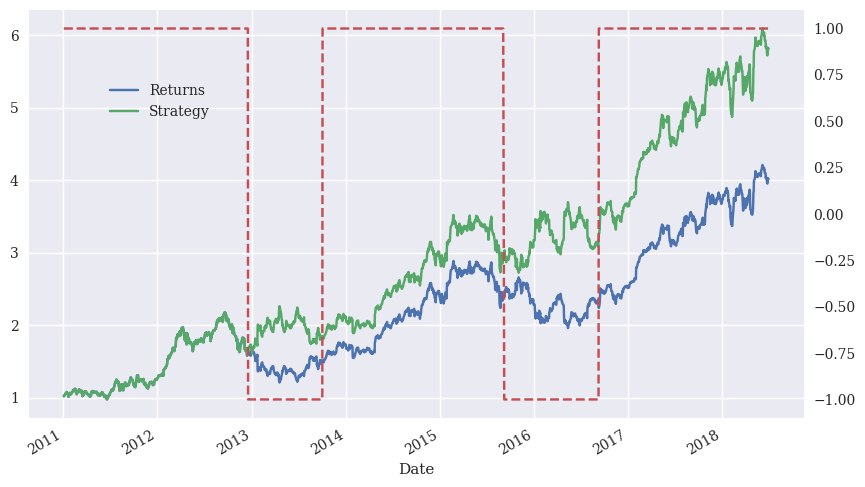

In [84]:
ax = data[['Returns', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
data['Position'].plot(ax=ax, secondary_y='Position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));

## Optimization

In [85]:
from itertools import product

In [86]:
sma1 = range(20, 61, 4)     # specifies the parameter values for SMA1
sma2 = range(180, 281, 10)  # specifies the parameter values for SMA2

In [87]:
results = pd.DataFrame()
for SMA1, SMA2 in product(sma1, sma2):  # combines all values for SMA1 with those for SMA2
    data = pd.DataFrame(raw[symbol])
    data.dropna(inplace=True)
    data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
    data['SMA1'] = data[symbol].rolling(SMA1).mean()
    data['SMA2'] = data[symbol].rolling(SMA2).mean()
    data.dropna(inplace=True)
    data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    data.dropna(inplace=True)
    perf = np.exp(data[['Returns', 'Strategy']].sum())

    # Create a temporary DataFrame for the current SMA pair
    temp_results = pd.DataFrame({
        'SMA1': [SMA1],
        'SMA2': [SMA2],
        'MARKET': [perf['Returns']],
        'STRATEGY': [perf['Strategy']],
        'OUT': [perf['Strategy'] - perf['Returns']]
    })

    # Use pd.concat instead of append
    results = pd.concat([results, temp_results], ignore_index=True)

In [88]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMA1      121 non-null    int64  
 1   SMA2      121 non-null    int64  
 2   MARKET    121 non-null    float64
 3   STRATEGY  121 non-null    float64
 4   OUT       121 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 4.9 KB


In [89]:
results.sort_values('OUT', ascending=False).head(7)

,SMA1,SMA2,MARKET,STRATEGY,OUT
56,40,190,4.650342,7.175173,2.524831
39,32,240,4.045619,6.558690,2.513071
59,40,220,4.220272,6.544266,2.323994
46,36,200,4.074753,6.389627,2.314874
55,40,180,4.574979,6.857989,2.283010
70,44,220,4.220272,6.469843,2.249571
101,56,200,4.074753,6.319524,2.244772


## Random Walk Hypothesis

In [90]:
symbol = '.SPX'

In [91]:
data = pd.DataFrame(raw[symbol])

In [92]:
lags = 5
cols = []
for lag in range(1, lags+1):
    col = 'lag_{}'.format(lag)  # defines a column name for the current lag value
    data[col] = data[symbol].shift(lag) # creates the lagged version of the market prices for the current lag value
    cols.append(col)    # collects the column names for later reference

In [93]:
data.head(7)

,.SPX,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,1132.99,NaN,NaN,NaN,NaN,NaN
2010-01-05,1136.52,1132.99,NaN,NaN,NaN,NaN
2010-01-06,1137.14,1136.52,1132.99,NaN,NaN,NaN
2010-01-07,1141.69,1137.14,1136.52,1132.99,NaN,NaN
2010-01-08,1144.98,1141.69,1137.14,1136.52,1132.99,NaN
2010-01-11,1146.98,1144.98,1141.69,1137.14,1136.52,1132.99


# Linear OLS Regression

## The Data

In [94]:
raw = pd.read_csv('/Users/cherongtian/Desktop/PythonforFinance/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True).dropna()

In [95]:
raw.columns

Index(['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX', '.VIX',
       'EUR=', 'XAU=', 'GDX', 'GLD'],
      dtype='object')

In [96]:
symbol = 'EUR='

In [97]:
data = pd.DataFrame(raw[symbol])

In [98]:
data['returns'] = np.log(data / data.shift(1))

In [99]:
data.dropna(inplace=True)

In [100]:
data['direction'] = np.sign(data['returns']).astype(int)

In [101]:
data.head()

,EUR=,returns,direction
Date,,,
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1
2010-01-11,1.4513,0.006984,1


<Axes: >

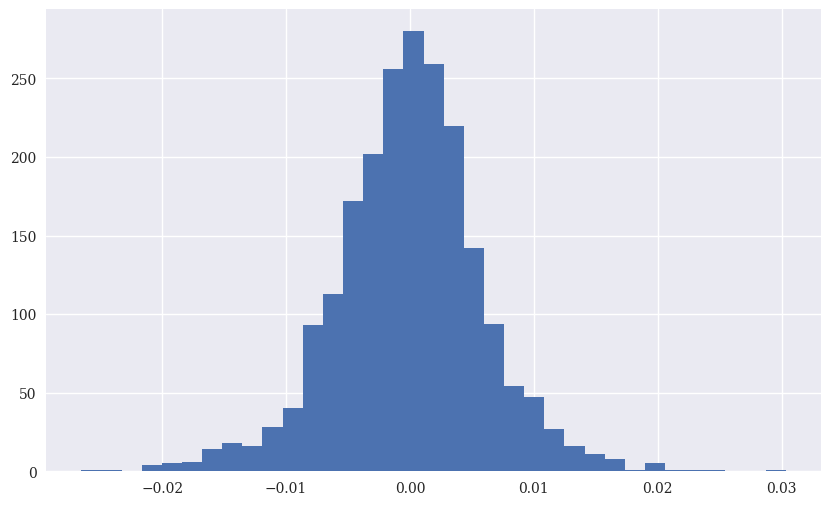

In [102]:
data['returns'].hist(bins=35, figsize=(10, 6))

In [103]:
lags = 2

In [104]:
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)

In [105]:
create_lags(data)

In [106]:
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-05,1.4368,-0.002988,-1,NaN,NaN
2010-01-06,1.4412,0.003058,1,-0.002988,NaN
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544


In [107]:
data.dropna(inplace=True)

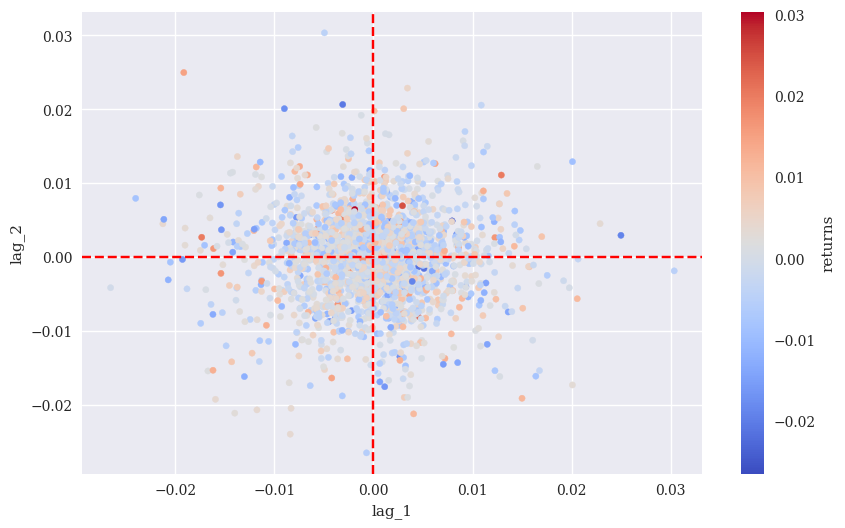

In [108]:
data.plot.scatter(x='lag_1', y='lag_2', c='returns',
                  cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--');

## Regression

In [109]:
from sklearn.linear_model import LinearRegression   # the linear OLS regression implementation from scikit-learn is used

In [110]:
model = LinearRegression()

In [111]:
data['pos_ols_1'] = model.fit(data[cols],
                              data['returns']).predict(data[cols])     # the regression is implemented on the log return...

In [112]:
data['pos_ols_2'] = model.fit(data[cols],
                              data['direction']).predict(data[cols])    # ... and on the direction data which is of primary interest

In [113]:
data[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
Date,,
2010-01-07,-0.000166,-0.000086
2010-01-08,0.000017,0.040404
2010-01-11,-0.000244,-0.011756
2010-01-12,-0.000139,-0.043398
2010-01-13,-0.000022,0.002237


In [114]:
data[['pos_ols_1', 'pos_ols_2']] = np.where(data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)    
# the real-valued predictions are transformed to directional predictions in general

In [115]:
data['pos_ols_1'].value_counts()

pos_ols_1
-1    1847
 1     288
Name: count, dtype: int64

In [116]:
data['pos_ols_2'].value_counts()    
# the two approaches yield different directional predictions in general

pos_ols_2
 1    1377
-1     758
Name: count, dtype: int64

In [117]:
(data['pos_ols_1'].diff()!= 0).sum()

555

In [118]:
(data['pos_ols_2'].diff()!= 0).sum()
# however, both lead to relatively large number of trades over time

762

In [119]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']

data[['returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

returns        0.810644
strat_ols_1    0.942422
strat_ols_2    1.339286
dtype: float64

In [120]:
(data['direction'] == data['pos_ols_1']).value_counts()

False    1093
True     1042
Name: count, dtype: int64

In [121]:
(data['direction'] == data['pos_ols_2']).value_counts()
# shows the number of correct and false prdictions by the strategies

True     1096
False    1039
Name: count, dtype: int64

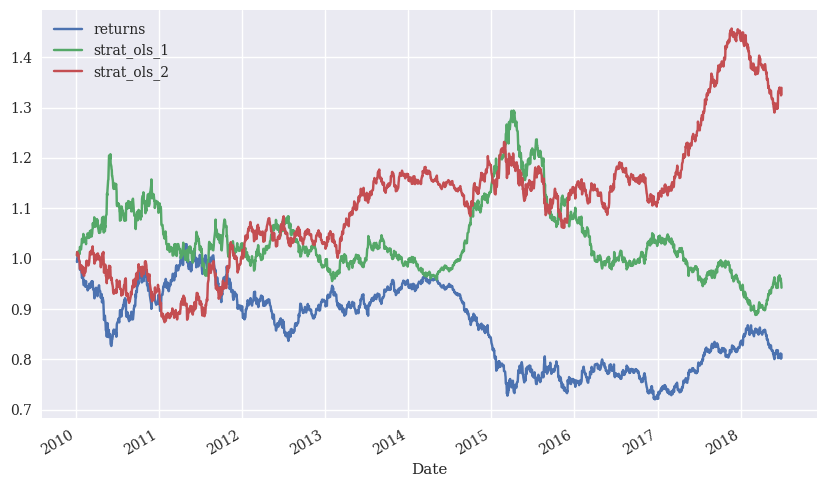

In [122]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].cumsum().apply(np.exp).plot(figsize=(10, 6));

# Clustering

In [123]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2, random_state=0)    # two clusters are chosen for the algorithm
model.fit(data[cols])

KMeans(n_clusters=2, random_state=0)

In [124]:
data['pos_clus'] = model.predict(data[cols])
data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)   # given the cluster values, the position is chosen
data['pos_clus'].values

array([ 1,  1,  1, ..., -1,  1,  1])

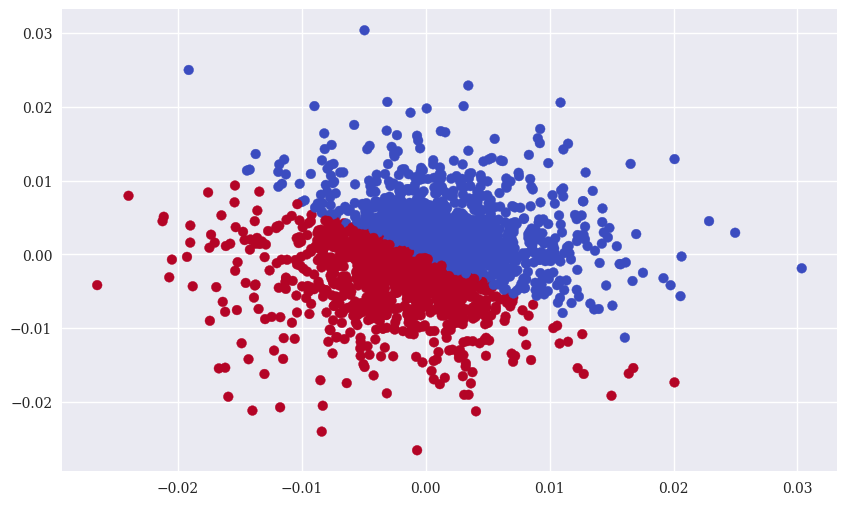

In [125]:
plt.figure(figsize=(10, 6))
plt.scatter(data[cols].iloc[:, 0],
            data[cols].iloc[:, 1],
            c=data['pos_clus'],
            cmap='coolwarm');

In [126]:
data['strat_clus'] = data['pos_clus'] * data['returns']
data[['returns', 'strat_clus']].sum().apply(np.exp)

returns       0.810644
strat_clus    1.150545
dtype: float64

In [127]:
(data['direction'] == data['pos_clus']).value_counts()

True     1098
False    1037
Name: count, dtype: int64

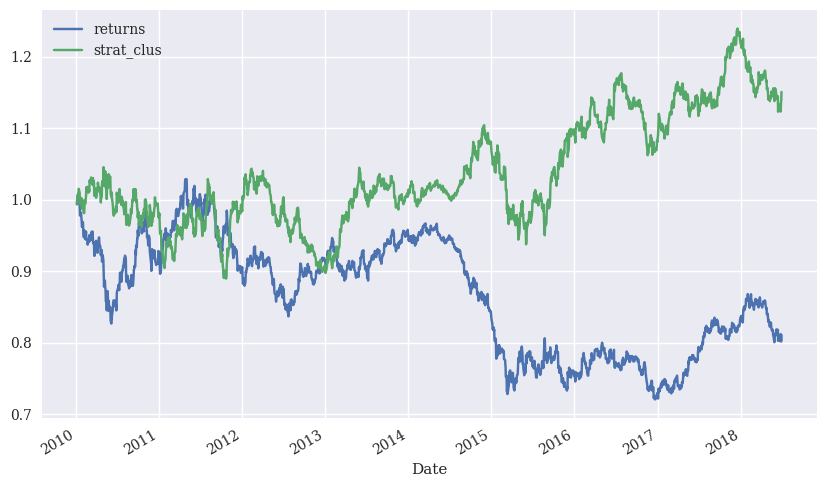

In [128]:
data[['returns', 'strat_clus']].cumsum().apply(np.exp).plot(figsize=(10, 6));

## Frequency Approach

In [129]:
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)   # Digitalizes the feature values given the bins parameter
        cols_bin.append(col_bin)

In [130]:
create_bins(data)
data[cols_bin + ['direction']].head()   # Shows the digitalized feature values and the label values

,lag_1_bin,lag_2_bin,direction
Date,,,
2010-01-07,1,0,-1
2010-01-08,0,1,1
2010-01-11,1,0,1
2010-01-12,1,1,-1
2010-01-13,0,1,1


In [131]:
grouped = data.groupby(cols_bin + ['direction'])
grouped.size()  # Shows the frequency of the possible movements conditional on the feature value combinatioins

lag_1_bin  lag_2_bin  direction
0          0          -1           239
                       0             4
                       1           258
           1          -1           262
                       1           288
1          0          -1           272
                       0             1
                       1           278
           1          -1           278
                       0             4
                       1           251
dtype: int64

In [132]:
res = grouped['direction'].size().unstack(fill_value=0)    # Transforms the DataFrame object to have the frequencies in columns

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]    # Highlights the highest-frequency value per feature value combination

res.style.apply(highlight_max, axis=1)

In [133]:
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) == 2, -1, 1)    # Translates the findings given the frequencies to a trading strategy

(data['direction'] == data['pos_freq']).value_counts()

True     1102
False    1033
Name: count, dtype: int64

In [134]:
data['strat_freq'] = data['pos_freq'] * data['returns']

data[['returns', 'strat_freq']].sum().apply(np.exp)

returns       0.810644
strat_freq    0.989513
dtype: float64

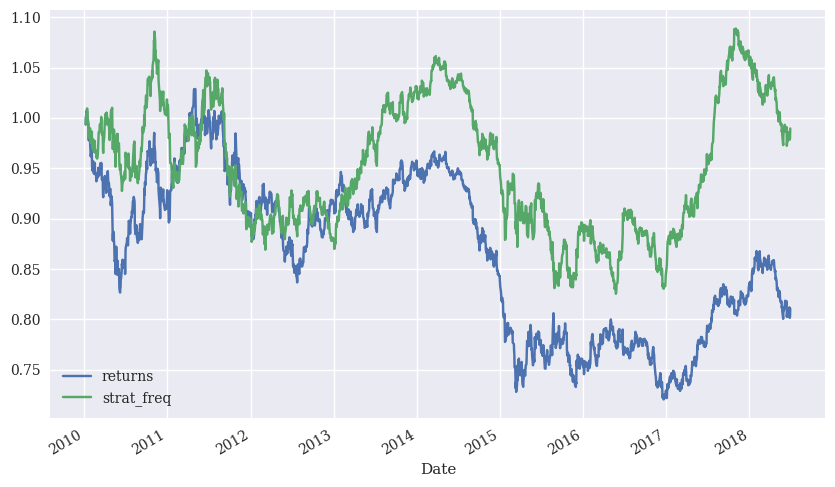

In [135]:
data[['returns', 'strat_freq']].cumsum().apply(np.exp).plot(figsize=(10, 6));

# Classification

## Two Binary Features

In [136]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [137]:
C = 1

In [141]:
models = {
    'log_reg' : linear_model.LogisticRegression(C=C),
    'gauss_nb' : GaussianNB(),
    'svm' : SVC(C=C)
}

In [142]:
def fit_models(data):   # A function that fits all models
    mfit = {model : models[model].fit(data[cols_bin], data['direction']) for model in models.keys()}

In [143]:
fit_models(data)

In [144]:
def derive_positions(data):    # A function that derives all postion values from the fitted models 
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [146]:
derive_positions(data)

In [147]:
def evaluate_strats(data):  # A function that evaluates all resulting trading strategies
    global sel
    sel = []
    for model in models.keys():
        col = 'strat_' + model
        data[col] = data['pos_' + model] * data['returns']
        sel.append(col)
    sel.insert(0, 'returns')

evaluate_strats(data)

sel.insert(1, 'strat_freq')

data[sel].sum().apply(np.exp)   # Some strategies might show the exact same performance

returns           0.810644
strat_freq        0.989513
strat_log_reg     1.243322
strat_gauss_nb    1.243322
strat_svm         0.989513
dtype: float64

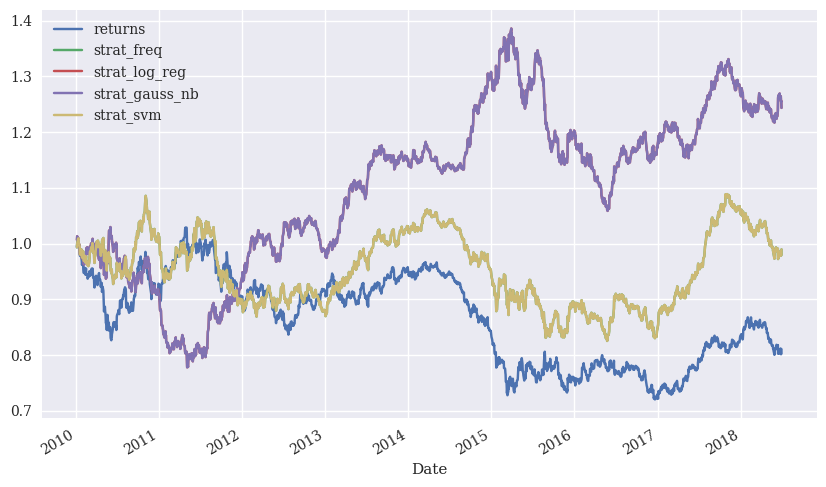

In [148]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

## Five Binary Features

In [150]:
data = pd.DataFrame(raw[symbol])
data['returns'] = np.log(data / data.shift(1))
data['direction'] = np.sign(data['returns'])

lags = 5    # five lags of the log returns series are now used
create_lags(data)
data.dropna(inplace=True)

create_bins(data)   # the real-valued features data is transformed to binary data
cols_bin

['lag_1_bin', 'lag_2_bin', 'lag_3_bin', 'lag_4_bin', 'lag_5_bin']

In [151]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,1,1,0,1,0
2010-01-13,0,1,1,0,1
2010-01-14,1,0,1,1,0
2010-01-15,0,1,0,1,1
2010-01-19,0,0,1,0,1


In [152]:
data.dropna(inplace=True)
fit_models(data)
derive_positions(data)
evaluate_strats(data)
data[sel].sum().apply(np.exp)

returns           0.805002
strat_log_reg     0.971623
strat_gauss_nb    0.986420
strat_svm         2.649423
dtype: float64

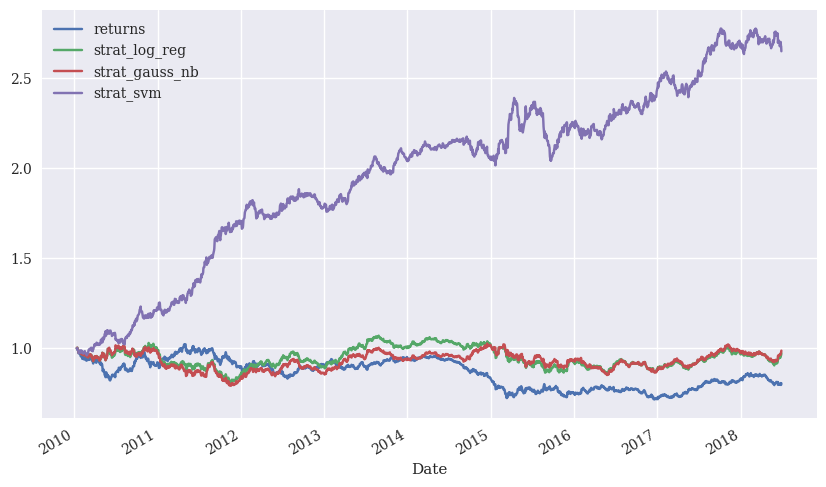

In [153]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

## Five Digitized Features

In [154]:
mu = data['returns'].mean()    # the mean log return and ...
v = data['returns'].std()   # ... standard deviation are used ...
bins = [mu - v, mu, mu + v]    # ... to digitize the features data
bins

[-0.006033537040418664, -0.00010174015279231288, 0.005830056734834038]

In [155]:
create_bins(data, bins)
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-15,1,2,1,3,3
2010-01-19,0,1,2,1,3


In [157]:
fit_models(data)
derive_positions(data)
evaluate_strats(data)
data[sel].sum().apply(np.exp)

returns           0.805002
strat_log_reg     1.431120
strat_gauss_nb    1.815304
strat_svm         7.165290
dtype: float64

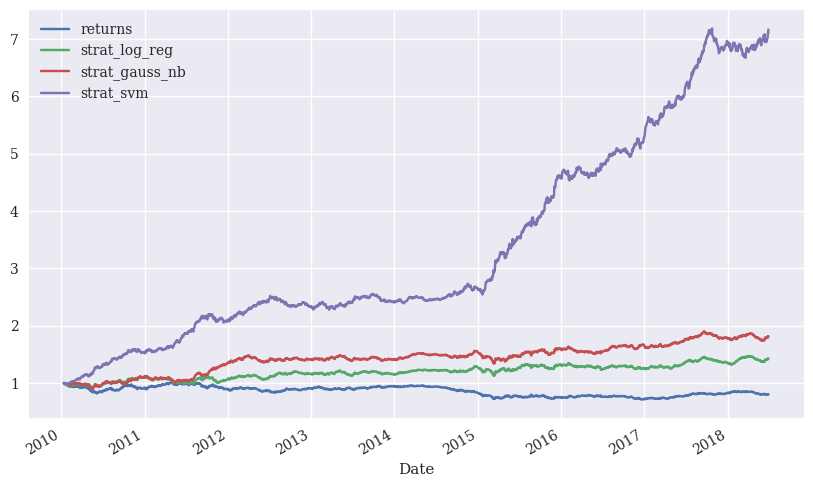

In [158]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

## Sequential Train-Test Spilt

In [159]:
spilt = int(len(data) * 0.5)
train = data.iloc[:spilt].copy()    # trains all classification algorithms on the training data
fit_models(train)

test = data.iloc[spilt:].copy()    # tests all classification algorithms on the test data
derive_positions(test)
evaluate_strats(test)

test[sel].sum().apply(np.exp)

returns           0.850291
strat_log_reg     0.952898
strat_gauss_nb    0.941172
strat_svm         1.020519
dtype: float64

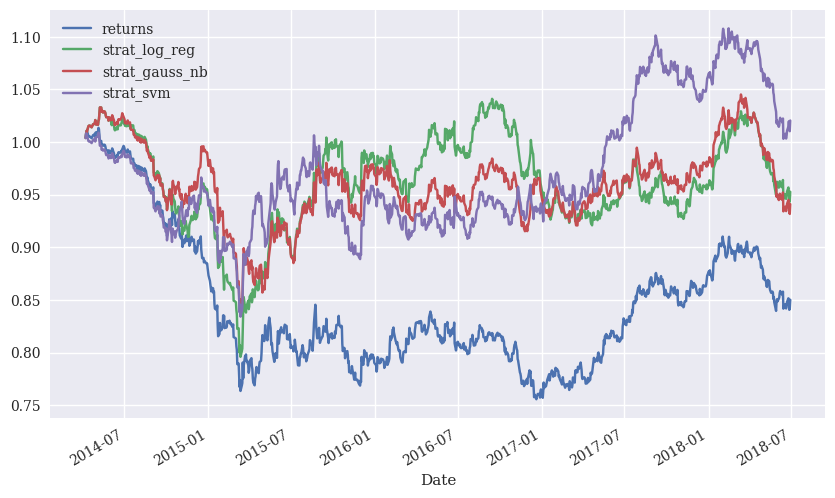

In [160]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

## Randomized Train-Test Split

In [162]:
from sklearn.model_selection import train_test_split

In [163]:
train, test = train_test_split(data, test_size=0.5, shuffle=True, random_state=100)
train = train.copy().sort_index()   # train and test data sets are copied and brought back in temporal order
train[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-15,1,2,1,3,3
2010-01-20,1,0,1,2,1


In [164]:
test = test.copy().sort_index()
fit_models(train)
derive_positions(test)
evaluate_strats(test)
test[sel].sum().apply(np.exp)

returns           0.878078
strat_log_reg     0.801787
strat_gauss_nb    0.765009
strat_svm         0.730141
dtype: float64

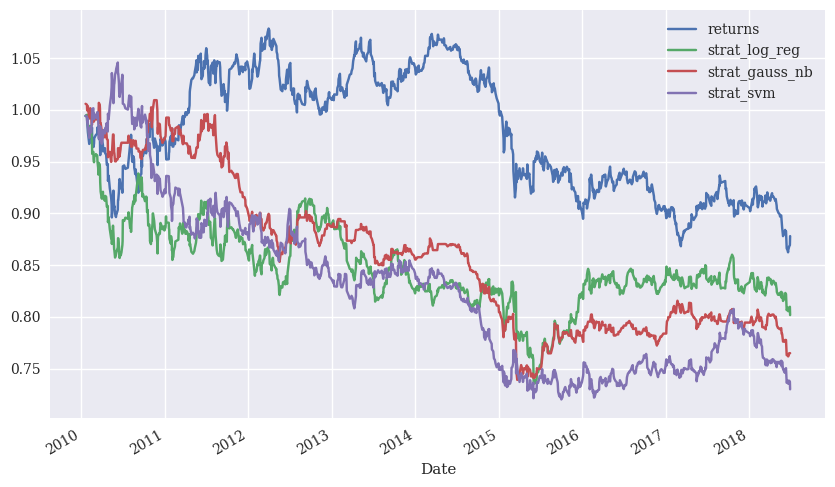

In [165]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

# Deep Neural Networks

## DNNs with scikit-learn

In [166]:
from sklearn.neural_network import MLPClassifier

In [168]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=2*[250], random_state=1)

In [169]:
%time model.fit(data[cols_bin], data['direction'])

CPU times: user 18min 5s, sys: 3min 22s, total: 21min 27s
Wall time: 1min 49s


/Users/cherongtian/Desktop/python/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[250, 250], random_state=1,
              solver='lbfgs')

In [170]:
data['pos_dnn_sk'] = model.predict(data[cols_bin])
data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['returns']
data[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns          0.805002
strat_dnn_sk    42.113843
dtype: float64

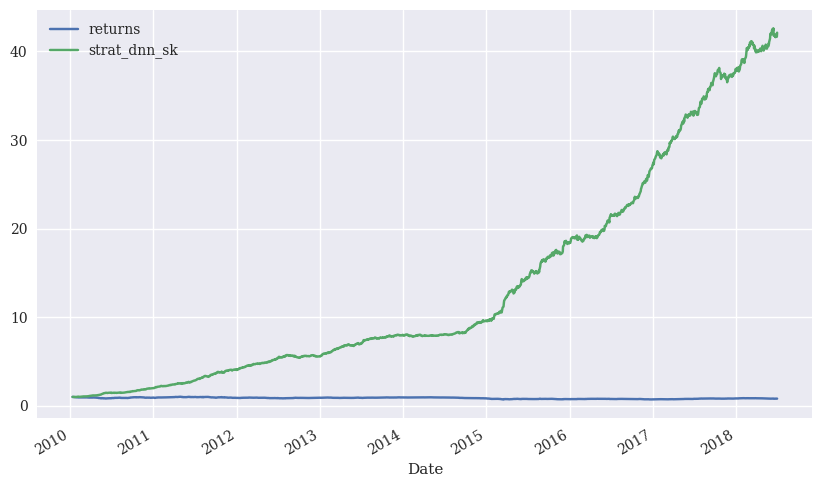

In [171]:
data[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [172]:
train, test = train_test_split(data, test_size=0.5, random_state=100)
train = train.copy().sort_index()
test = test.copy().sort_index()
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500, hidden_layer_sizes=3 * [500], random_state=1)
# increases the number of hidden layers and hidden units

In [173]:
%time model.fit(train[cols_bin], train['direction'])

CPU times: user 48min 47s, sys: 9min 9s, total: 57min 56s
Wall time: 4min 56s


/Users/cherongtian/Desktop/python/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[500, 500, 500], max_iter=500,
              random_state=1, solver='lbfgs')

In [174]:
test['pos_dnn_sk'] = model.predict(test[cols_bin])
test['strat_dnn_sk'] = test['pos_dnn_sk'] * test['returns']
test[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns         0.878078
strat_dnn_sk    1.190807
dtype: float64

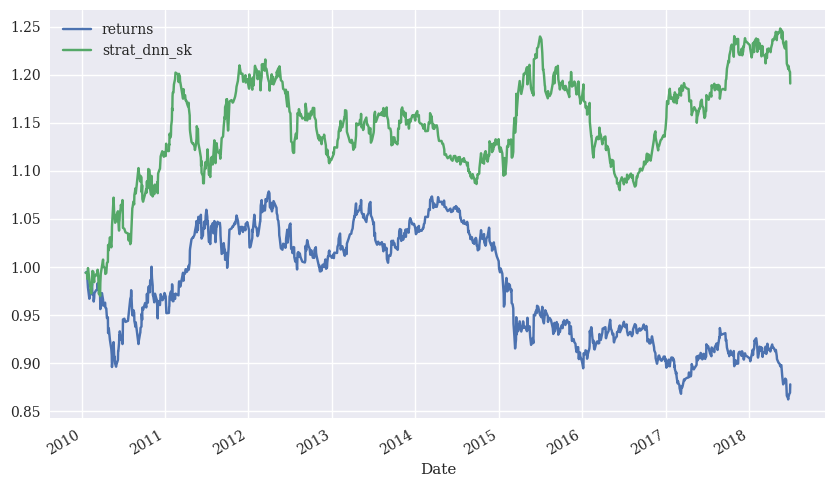

In [175]:
test[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));

## DNNs with TensorFlow

In [178]:
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)